In [37]:
%%capture
from torchreid.utils import FeatureExtractor

extractor = FeatureExtractor(
            model_name='osnet_x1_0',
            model_path='/Users/nilez/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth',
            device='cpu')

In [38]:
video_path = lambda x: f"/Users/walkenz1/Datasets/grandma/train/cam_{int(x)}/cam_{int(x)}.mp4"
coords_path = lambda x: f"/Users/walkenz1/Datasets/grandma/train/cam_{int(x)}/coords_fib_cam_{int(x)}.csv"

In [43]:
import cv2
import numpy as np
import pandas as pd

person_instances = dict()

for i in [0,1]:
    
    df = pd.read_csv(coords_path(i))
    cap = cv2.VideoCapture(video_path(i))
    person_instances[i] = dict()
    
    frame_num = 0 
    ret = True 
    interval = 1
    
    while ret:
        for _ in range(interval):
            ret, img = cap.read()
        if not ret: break
        boxes = df[df.frame_no_cam == frame_num]
        if len(boxes) != 0:
            for index, row in boxes.iterrows():
                
                x1,x2,y1,y2 = row["x_top_left_BB"], row["x_bottom_right_BB"], row["y_top_left_BB"], row["y_bottom_right_BB"]
                x1 = x1 if x1 > 0 else 0
                y1 = y1 if y1 > 0 else 0
                crop = img[y1:y2,x1:x2]

                
                if row["person_id"] in [0,1]:
                    feature_vector = np.array(extractor(crop)[0]) # For Later
                    if row["person_id"] not in person_instances[i]:
                        person_instances[i][row["person_id"]] = [] 
                    person_instances[i][row["person_id"]].append(feature_vector)

        frame_num += interval
    cap.release()


In [40]:
lengths = []
grouped_embeddings = []
ids = []
for cam in person_instances:
    for person in person_instances[cam]:
        grouped_embeddings += person_instances[cam][person]
        ids.append(f"Cam: {cam} ID: {person}")
        lengths.append(len(person_instances[cam][person]))

In [ ]:
# X = np.array(grouped_embeddings)# np.concatenate([*grouped_embeddings])
# y_temp = np.zeros(len(grouped_embeddings))
# for i in range(len(lengths)):
#     y_temp[sum(lengths[:i]):sum(lengths[:i + 1])] = i 
# y = y_temp

# from sklearn.neighbors import KNeighborsClassifier

# neigh = KNeighborsClassifier(n_neighbors=3)
# neigh.fit(X, y)

# print(neigh.predict([grouped_embeddings[5]]))
# print(neigh.predict_proba([grouped_embeddings[50]]))

In [42]:
lengths

[20, 13, 29, 4]

In [41]:
from sklearn.manifold import TSNE
import numpy as np

tsne_model_en_2d = TSNE(perplexity=3, n_components=2, init='pca', n_iter=2500)

embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(grouped_embeddings))
                         
temp = []
for i in range(len(lengths)):
    temp.append( embeddings_en_2d[sum(lengths[:i]):sum(lengths[:i + 1])])
    
embeddings_en_2d = temp

/Users/walkenz1/opt/anaconda3/envs/smart-campus/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/walkenz1/opt/anaconda3/envs/smart-campus/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [ ]:
embeddings_en_2d[0]

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, a, filename=None, solid_color = True):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for i, (label, embeddings, color) in enumerate(zip(labels, embedding_clusters, colors)):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        if solid_color:
            plt.scatter(x, y, c=np.arange(len(x)), alpha=a, label=label)
        else: 
            plt.scatter(x, y, c=color, alpha=a, label=label)
        # for i, word in enumerate(words):
        #     plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
        #                  textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


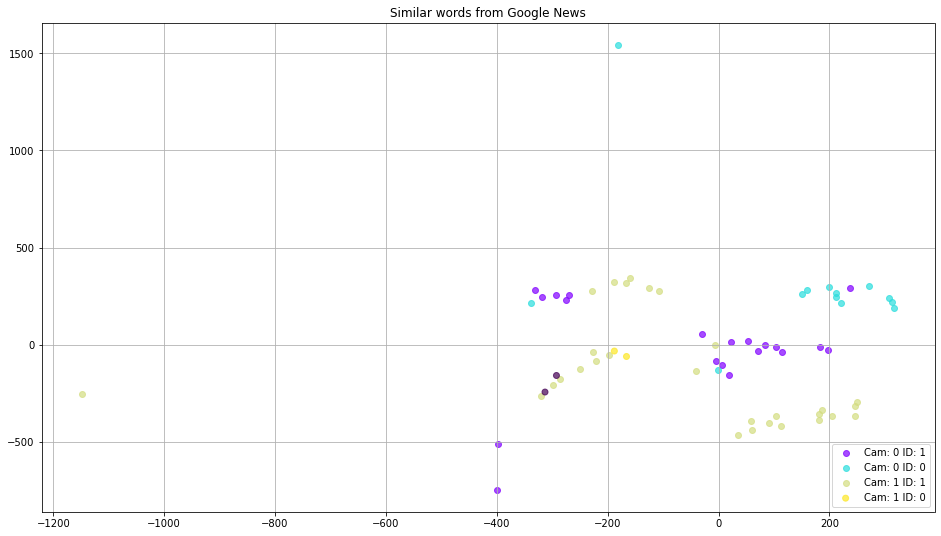

In [33]:
tsne_plot_similar_words('Similar words from Google News', ids, embeddings_en_2d, 0.7,
                        'similar_words.png', False)

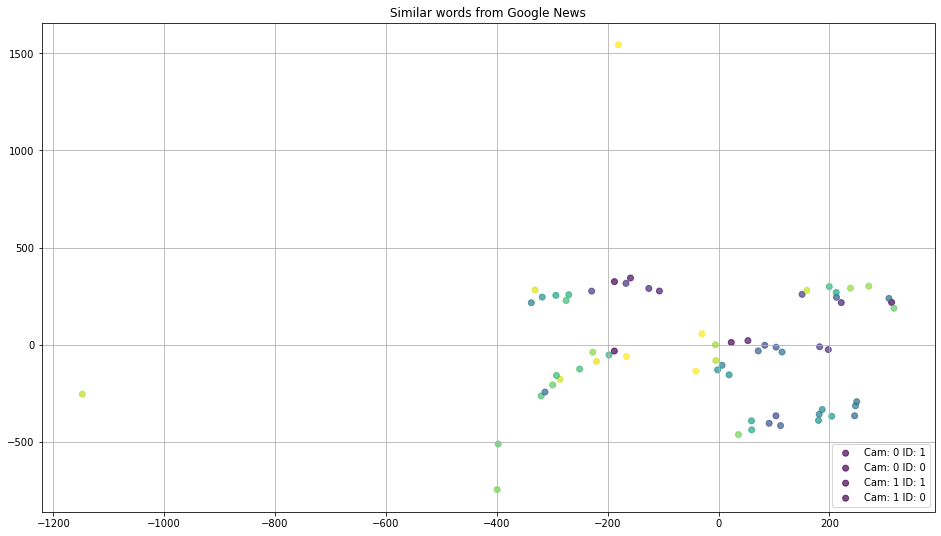

In [34]:
tsne_plot_similar_words('Similar words from Google News', ids, embeddings_en_2d, 0.7,
                        'similar_words.png')